## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Import modules for image processing

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

In [17]:
## Some my tests
img_test = cv2.imread('test_images/test1.jpg')
img_test_gray = cv2.cvtColor(img_test, cv2.COLOR_RGB2GRAY)

### Compute the camera calibration using chessboard images

In [10]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9
ny = 6
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:                       
        objpoints.append(objp)
        imgpoints.append(corners)

# perform camera calibration
[ret, mtx, dist, rvecs, tvecs] = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]),None,None)

Now we have distortion coefficients: 

In [15]:
print(dist)

[[-0.24688775 -0.02373133 -0.00109842  0.00035108 -0.00258571]]


Camera matrix:

In [16]:
print(mtx)

[[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128937e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


and position of the camera in the world.

### Apply a distortion correction to raw images

In [26]:
# Make a list of test images
images = glob.glob('test_images/test*.jpg')
undistort_images = []

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    # Undistort image
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    undistort_images.append(img_undist)

### Show last test result (look at corners)

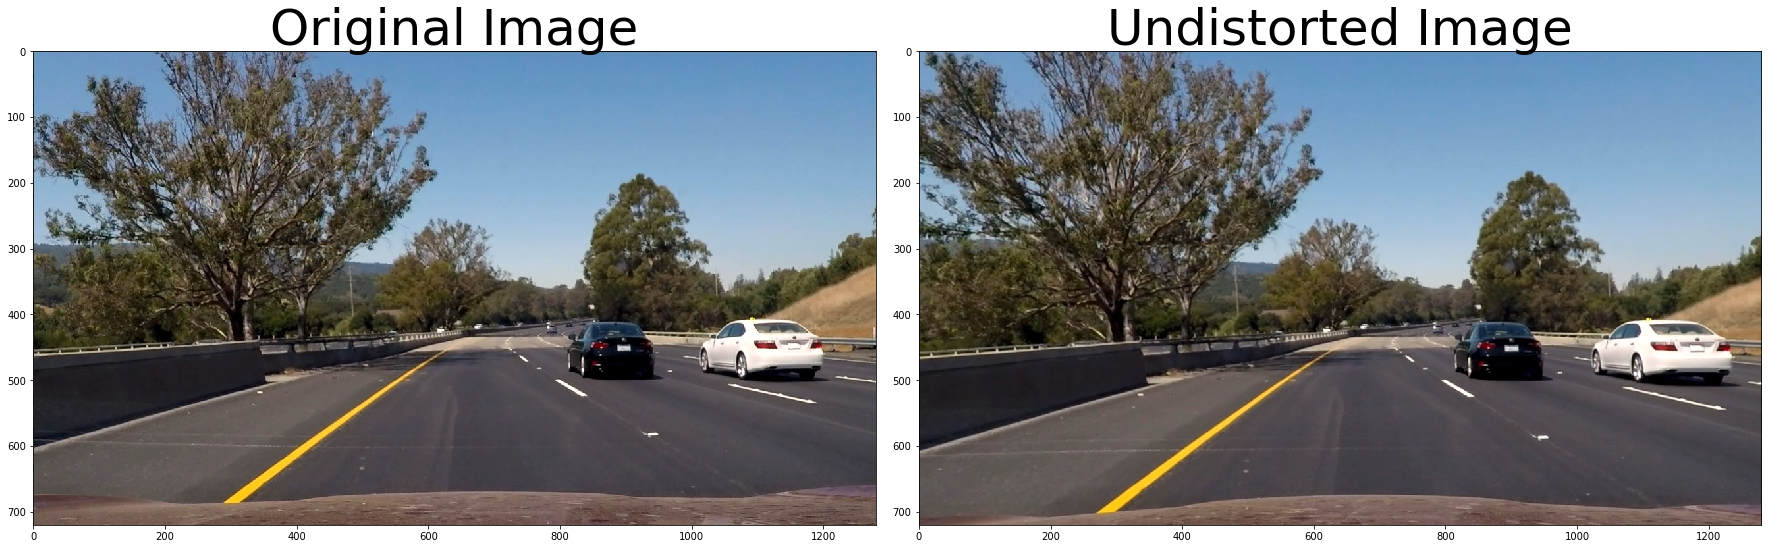

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Color spaces and gradient

In [155]:

def abs_sobel_thresh(image, orient='x', thresh=(0, 255)):
    if len(image.shape) > 2:
        print("Input image has more than one color channel. Converting to grayscale.")
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy
    binary_output = np.zeros_like(scaled_sobel)
    # apply the threshold
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the binary image
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    if len(image.shape) > 2:
        print("Input image has more than one color channel. Converting to grayscale.")
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    if len(image.shape) > 2:
        print("Input image has more than one color channel. Converting to grayscale.")
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

def get_S_channel(img_rgb):
    hls_img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    s_channel_img = hls_img[:,:,2]
    return s_channel_img

def get_L_channel(img_rgb):
    hls_img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    l_channel_img = hls_img[:,:,1]
    return l_channel_img

def get_V_channel_Luv(img_rgb):
    luv_img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Luv)
    v_channel_img = luv_img[:,:,2]
    return v_channel_img

In [181]:
# 1. Convert to HLS color space and separate the S channel
def convert_and_threshold(input_img):
    # 0. Get S channel from input image
    s_channel_img = get_S_channel(input_img)
    v_channel_img = get_V_channel_Luv(input_img)
    
    # 1. Calculate absolute threshold and magnitude threshold for l channel of luv image
    abs_sobel_bin_img = abs_sobel_thresh(v_channel_img, orient='x', thresh=(30, 70)) 
    mag_thresh_bin_img = mag_thresh(v_channel_img, sobel_kernel=5, mag_thresh=(30, 70))
    
    # 2.  Calculate absolute threshold and magnitude threshold for grayscale image
    abs_sobel_bin_img_gray = abs_sobel_thresh(s_channel_img, orient='x', thresh=(20, 70))  
    mag_thresh_bin_img_gray = mag_thresh(s_channel_img, sobel_kernel=15, mag_thresh=(30, 50))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_channel_img)
    combined_binary[((abs_sobel_bin_img == 1) & (mag_thresh_bin_img == 1))
                    | ((abs_sobel_bin_img_gray == 1) | (mag_thresh_bin_img_gray == 1))] = 1

    # Plotting thresholded images
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
                                    ncols=2,
                                    nrows=3,
                                    figsize=(20,10))
    
    ax1.set_title('Absolute Sobel')
    ax1.imshow(abs_sobel_bin_img, cmap='gray')
    
    ax2.set_title('Magnitute threshold')
    ax2.imshow(mag_thresh_bin_img, cmap='gray')
    
    ax3.set_title('Absolute Sobel - Grayscale')
    ax3.imshow(abs_sobel_bin_img_gray, cmap='gray')
    
    ax4.set_title('Magnitute threshold - Grayscale')
    ax4.imshow(mag_thresh_bin_img_gray, cmap='gray')

    ax5.set_title('V channel')
    ax5.imshow(s_channel_img, cmap='gray')
    
    ax6.set_title('Combined thresholds')
    ax6.imshow(combined_binary, cmap='gray')
    
    return combined_binary
    
#for img in undistort_images:
#    convert_and_threshold(img)

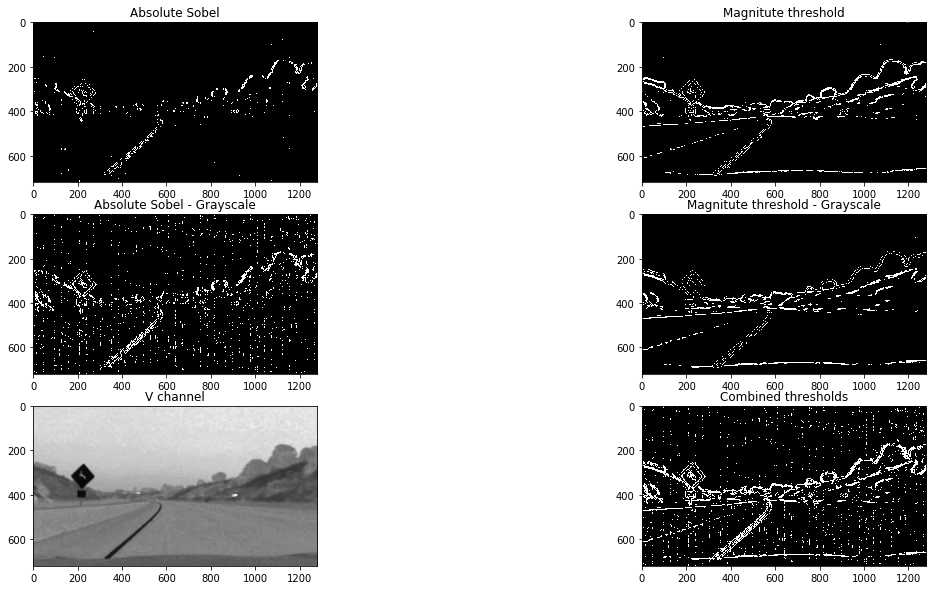

In [182]:
## Some my tests
img_test = cv2.imread('test_images/test2.jpg')
combined_binary = convert_and_threshold(img_test)

### Perspective transformation

#### Select points on reference image

In [13]:
def roi(img,vertices):
    # blank mask:
    mask = np.zeros_like(img)

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, 255)

    # returning the image only where mask pixels are nonzero
    masked = cv2.bitwise_and(img, mask)
    return masked

In [30]:
img_ref = cv2.imread('test_images/straight_lines1.jpg')

points = []
window_name = 'Choose source points'
cv2.namedWindow(window_name)
cv2.imshow(window_name, img_ref)
count = 0

"""
1. Choose upper left points
2. Choose upper right point
3. Choose bottom right point
4. Choose bottom left point 
"""

def mouseCB(event,x,y,flags,param):
    global count
    if event == cv2.EVENT_LBUTTONDBLCLK or event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(img_ref, (x, y), 3, (0, 0, 255), 3) #BGR
        if count == 0:
            cv2.line(img_ref, (x, y), (img_ref.shape[1], y), (0, 0, 255), 3)
        if count == 2:
            cv2.line(img_ref, (0, y), (x, y), (0, 0, 255), 3)
        count += 1
        points.append([x, y])
        cv2.imshow(window_name, img_ref)

cv2.setMouseCallback(window_name, mouseCB)
        
while True:
    ip = cv2.waitKey(0) & 0xFF
    if ip == ord('q'):
        break

cv2.destroyAllWindows()

In [24]:
# We suppose that lines are parallel
offset = 50 #distance from line

points_list = []
# upper left point
x = points[0][0] - offset
y = points[0][1]
points_list.append([x, y])
# upper right point
x = points[1][0] + offset
y = points[0][1] # on the same level as upper left point
points_list.append([x, y])
# bottom right point
x = points[2][0] + offset
y = points[2][1]
points_list.append([x, y])
# bottom left point
x = points[3][0] - offset
y = points[2][1]
points_list.append([x, y])

vertices = np.array([points_list], dtype=np.int32)

[[511, 470], [769, 470], [1083, 670], [226, 670]]


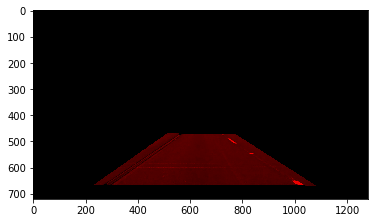

In [25]:
print(points_list)
masked_img = roi(img_ref, vertices)
plt.imshow(masked_img)

In [26]:
[x, y, z] = img_ref.shape
dst = np.float32([[0,0],[x,0],[x,y],[0,y]])

In [27]:
src = np.float32(points)
M = cv2.getPerspectiveTransform(src, dst)

In [28]:
img_size = (img_ref.shape[1], img_ref.shape[0])
warped = cv2.warpPerspective(img_ref, M, img_size, flags=cv2.INTER_LINEAR)

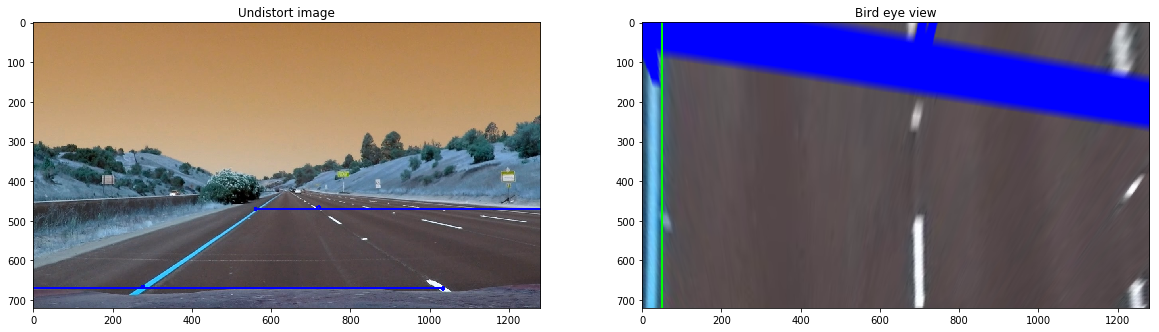

In [29]:
fig, ((ax1, ax2)) = plt.subplots(ncols=2,
                                nrows=1,
                                figsize=(20,10))
    
ax1.set_title('Undistort image')
ax1.imshow(img_ref)

lineThickness = 2
x = 50
cv2.line(warped, (x, 0), (x, y), (0,255,0), lineThickness)

ax2.set_title('Bird eye view')
ax2.imshow(warped)

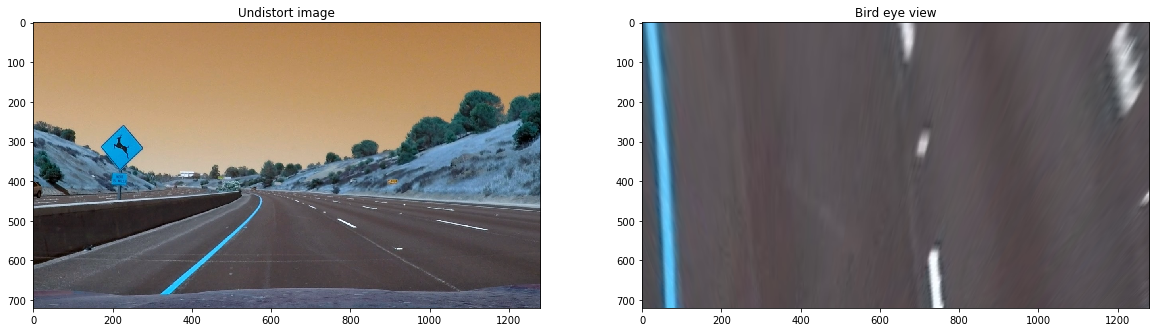

In [31]:
# Try the same M on curved left
img_ref_curve = cv2.imread('test_images/test2.jpg')
img_size = (img_ref_curve.shape[1], img_ref_curve.shape[0])
warped_curve = cv2.warpPerspective(img_ref_curve, M, img_size, flags=cv2.INTER_LINEAR)

fig, ((ax1, ax2)) = plt.subplots(ncols=2,
                                nrows=1,
                                figsize=(20,10))

ax1.set_title('Undistort image')
ax1.imshow(img_ref_curve)
    
ax2.set_title('Bird eye view')
ax2.imshow(warped_curve)

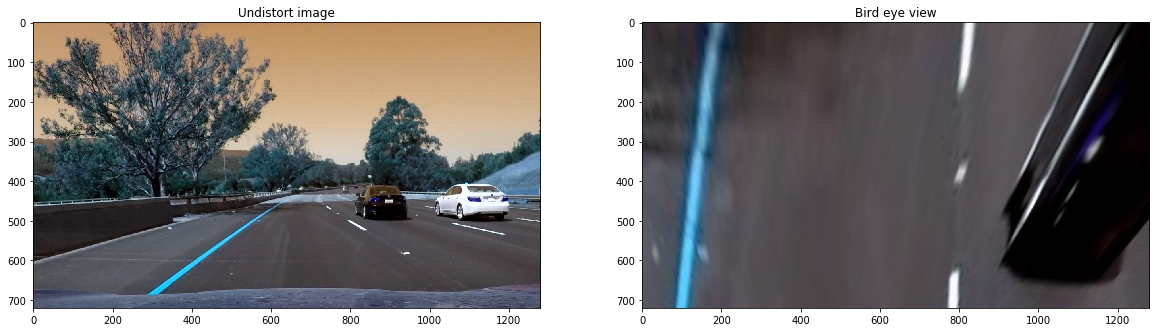

In [32]:
# Try the same M on curved right
img_ref_curve_right = cv2.imread('test_images/test6.jpg')
img_size = (img_ref_curve_right.shape[1], img_ref_curve_right.shape[0])
warped_curve_right = cv2.warpPerspective(img_ref_curve_right, M, img_size, flags=cv2.INTER_LINEAR)

# Display
fig, ((ax1, ax2)) = plt.subplots(ncols=2,
                                nrows=1,
                                figsize=(20,10))

ax1.set_title('Undistort image')
ax1.imshow(img_ref_curve_right)
    
ax2.set_title('Bird eye view')
ax2.imshow(warped_curve_right)

In [33]:
## Locate the Lane Lines using histogram